In [1]:
import pandas as pd
import os

In [2]:
def load_nav(code):
    try:
        df = pd.read_pickle('data\%s.pkl'%code, compression='zip')
        df = df[['nav_date', 'adj_nav']]
        df['nav_date'] = pd.to_datetime(df['nav_date'])
        df.set_index('nav_date', inplace=True)
        df.sort_index(inplace=True)
        df.drop_duplicates(inplace=True)
        return df
    except Exception as e:
        print(e)
        return None

In [3]:
funds=pd.read_pickle('data\\funds.pkl')
funds300=pd.read_pickle('data\\funds300.pkl')
funds500=pd.read_pickle('data\\funds500.pkl')
funds1000=pd.read_pickle('data\\funds1000.pkl')
idx300=pd.read_pickle('data\\idx300.pkl')
idx500=pd.read_pickle('data\\idx500.pkl')
idx1000=pd.read_pickle('data\\idx1000.pkl')

In [4]:
def fund_prem_performance(funds, idx):
    idx_close = idx[['trade_date', 'close']].copy()
    idx_close['trade_date'] = pd.to_datetime(idx['trade_date'])
    idx_close.set_index('trade_date', inplace=True)
    idx_close.sort_index(inplace=True)
    idx_close.drop_duplicates(inplace=True)
    idx_close.columns = ['benchmark']
    nav_panel = None
    i=0
    for code in funds['ts_code']:
        nav = load_nav(code)
        if type(nav) is pd.DataFrame:
            i+=1
            # print(i, code, nav.shape)
            nav.columns = [code]
            if type(nav_panel) is type(None):
                nav_panel = nav
            else:
                nav_panel = nav_panel.merge(nav, left_index=True, right_index=True, how='outer')
            # print(nav_panel.shape)
    nav_panel.ffill(inplace=True)
    nav_panel = nav_panel.merge(idx_close, left_index=True, right_index=True, how='outer')
    nav_panel.ffill(inplace=True)
    ret_panel = nav_panel.pct_change()
    prem_panel = ret_panel.copy()
    for col in prem_panel.columns:
        prem_panel[col] = prem_panel[col] -  prem_panel['benchmark']
    prem_panel.drop('benchmark', axis=1, inplace=True)
    prem_ir = prem_panel.mean() / prem_panel.std()
    prem_cnt = prem_panel.count()
    prem_act_ret = (prem_panel+1).cumprod().tail(1) ** (245 / prem_cnt) - 1
    prem_act_ret = prem_act_ret.transpose()
    prem_act_ret.columns = ['act_ret']
    prem_cnt.name = 'count'
    prem_stat = prem_act_ret.merge(prem_cnt, left_index=True, right_index=True)
    prem_ir.name = 'IR'
    prem_stat = prem_stat.merge(prem_ir, left_index=True, right_index=True)
    prem_stat = prem_stat.merge(funds[['ts_code','name']], left_index=True, right_on='ts_code')
    return prem_stat, prem_panel


In [18]:
stat, panel = fund_prem_performance(funds300, idx300)

In [19]:
stat[stat['count']>500].sort_values('act_ret', ascending=False)

,act_ret,count,IR,ts_code,name
9914,0.119306,1093,0.062648,004788.OF,富荣沪深300增强A
9917,0.117565,1093,0.061097,004789.OF,富荣沪深300增强C
8455,0.090797,786,0.070759,007448.OF,长信沪深300指数增强C
10804,0.089827,1318,0.071263,673100.OF,西部利得沪深300指数增强A
7010,0.086196,570,0.090525,008238.OF,中泰沪深300指数增强A
...,...,...,...,...,...
13272,-0.051045,1844,-0.015203,000950.OF,易方达沪深300非银ETF联接A
13841,-0.055695,2204,-0.019636,161718.OF,招商沪深300高贝塔
13343,-0.056033,1882,-0.008732,161721.OF,招商沪深300地产A
12354,-0.059122,1444,-0.018398,960022.OF,博时裕富沪深300R


In [20]:
stat[stat['count']>500].sort_values('IR', ascending=False)

,act_ret,count,IR,ts_code,name
7010,0.086196,570,0.090525,008238.OF,中泰沪深300指数增强A
8426,0.079033,780,0.080632,007404.OF,华宝沪深300指数增强C
8070,0.082904,711,0.080355,007276.OF,银河沪深300指数增强C
7011,0.082467,570,0.080202,008239.OF,中泰沪深300指数增强C
8961,0.081439,876,0.071298,673101.OF,西部利得沪深300指数增强C
...,...,...,...,...,...
13272,-0.051045,1844,-0.015203,000950.OF,易方达沪深300非银ETF联接A
12354,-0.059122,1444,-0.018398,960022.OF,博时裕富沪深300R
8151,-0.045635,726,-0.018498,007800.OF,申万菱信沪深300价值C
13841,-0.055695,2204,-0.019636,161718.OF,招商沪深300高贝塔


<AxesSubplot:>

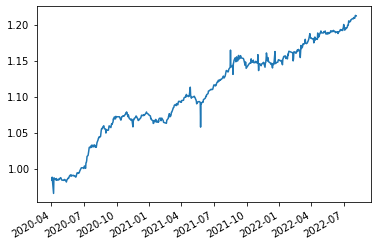

In [7]:
(panel['008238.OF']+1).cumprod().plot()

<AxesSubplot:>

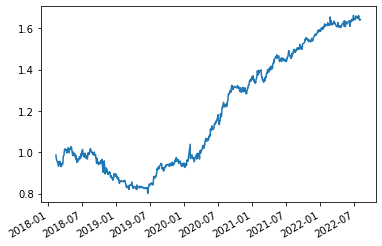

In [8]:
(panel['004789.OF']+1).cumprod().plot()

In [9]:
stat, panel = fund_prem_performance(funds500, idx500)

In [11]:
stat[stat['count']>500].sort_values('act_ret', ascending=False)

,act_ret,count,IR,ts_code,name
6954,0.177640,565,0.132714,009300.OF,西部利得中证500指数增强C
9472,0.143848,980,0.092505,005994.OF,国投瑞银中证500量化增强A
7041,0.141702,577,0.109602,007994.OF,华夏中证500指数增强A
7065,0.137316,577,0.105029,007995.OF,华夏中证500指数增强C
8729,0.135339,830,0.096824,007089.OF,国投瑞银中证500量化增强C
...,...,...,...,...,...
13079,-0.037243,1779,-0.005381,001052.OF,华夏中证500ETF联接A
8944,-0.037729,867,-0.020483,006129.OF,华安中证500低波动ETF联接A
7504,-0.038893,2619,-0.004425,590007.OF,中邮中证500指数增强A
8945,-0.048978,867,-0.028375,006130.OF,华安中证500低波动ETF联接C


<AxesSubplot:>

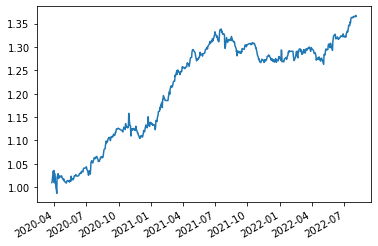

In [12]:
(panel['007994.OF']+1).cumprod().plot()

In [13]:
stat, panel = fund_prem_performance(funds1000, idx1000)

In [14]:
stat[stat['count']>500].sort_values('act_ret', ascending=False)

,act_ret,count,IR,ts_code,name
9994,0.172730,1101,0.082430,005313.OF,万家中证1000指数增强A
9995,0.162120,1101,0.076869,005314.OF,万家中证1000指数增强C
11194,0.127677,1375,0.078103,003646.OF,创金合信中证1000增强A
9114,0.125199,902,0.086851,006165.OF,建信中证1000指数增强A
11195,0.123682,1375,0.073363,003647.OF,创金合信中证1000增强C
9128,0.122370,902,0.095162,006166.OF,建信中证1000指数增强C
10896,0.114866,1329,0.080093,004194.OF,招商中证1000指数增强A
10907,0.110616,1329,0.070244,004195.OF,招商中证1000指数增强C
9210,-0.019909,917,-0.014215,006486.OF,广发中证1000A
9208,-0.022272,917,-0.015268,006487.OF,广发中证1000C


<AxesSubplot:>

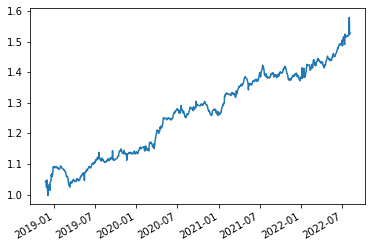

In [15]:
(panel['006166.OF']+1).cumprod().plot()

<AxesSubplot:>

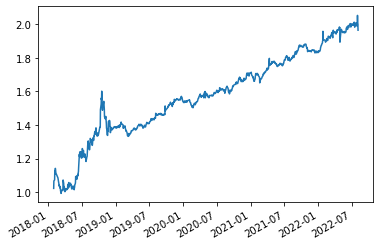

In [16]:
(panel['005314.OF']+1).cumprod().plot()